In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
plt.style.use("ggplot")
START_DATE = {
  'US': '1/22/20'
}
country = "US"
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
country_df = df[df['Country/Region'] == country]
data = country_df.iloc[0].loc[START_DATE[country]:]
data = data.to_numpy().astype(float)
data = data/1e4

## Raw Data

1/22/2020 - 5/3/2020, US confirmed cases (source: HDX)

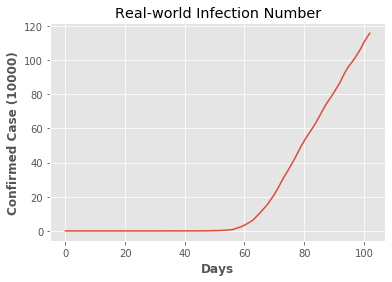

In [2]:
plt.plot(data)
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Confirmed Case (10000)",fontweight="bold")
plt.title("Real-world Infection Number")
plt.savefig("figures/real_number.jpg", bbox_inches='tight')

In [3]:
def sirmodel(y, t, N, num_cont, prob, gamma):
    beta = num_cont * prob
    S,I,R = y
    dsdt = -beta * I * S / N
    didt = beta * I * S / N - gamma * I
    drdt = gamma * I
    return dsdt, didt, drdt

# Initial simulation

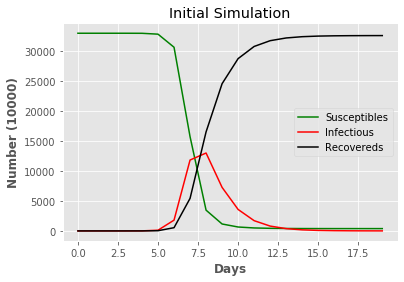

In [4]:
s0 = 3.3e4
i0 = 1e-4
r0 = 0
N = 3.3e4
num_cont = 18
prob = 0.2
gamma = 0.8
y0 = [s0, i0, r0]
t = np.arange(0,20,1)
result = odeint(sirmodel, y0, t, args=(N, num_cont, prob, gamma))
plt.plot(result[:,0], '-g', label='Susceptibles')
plt.plot(result[:,1], '-r', label='Infectious')
plt.plot(result[:,2], '-k', label='Recovereds')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Initial Simulation")
plt.savefig("figures/sir_init_all.jpg", bbox_inches='tight')

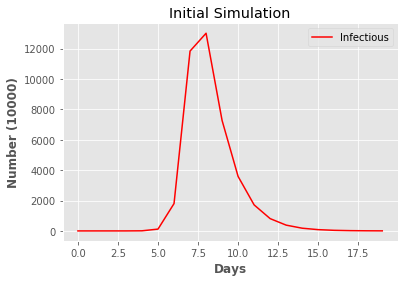

In [5]:
plt.plot(result[:,1], '-r', label='Infectious')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Initial Simulation")
plt.savefig("figures/sir_init_inf.jpg", bbox_inches='tight')

# One sample set of parameters

When the days = 100, the number of cases is above 100

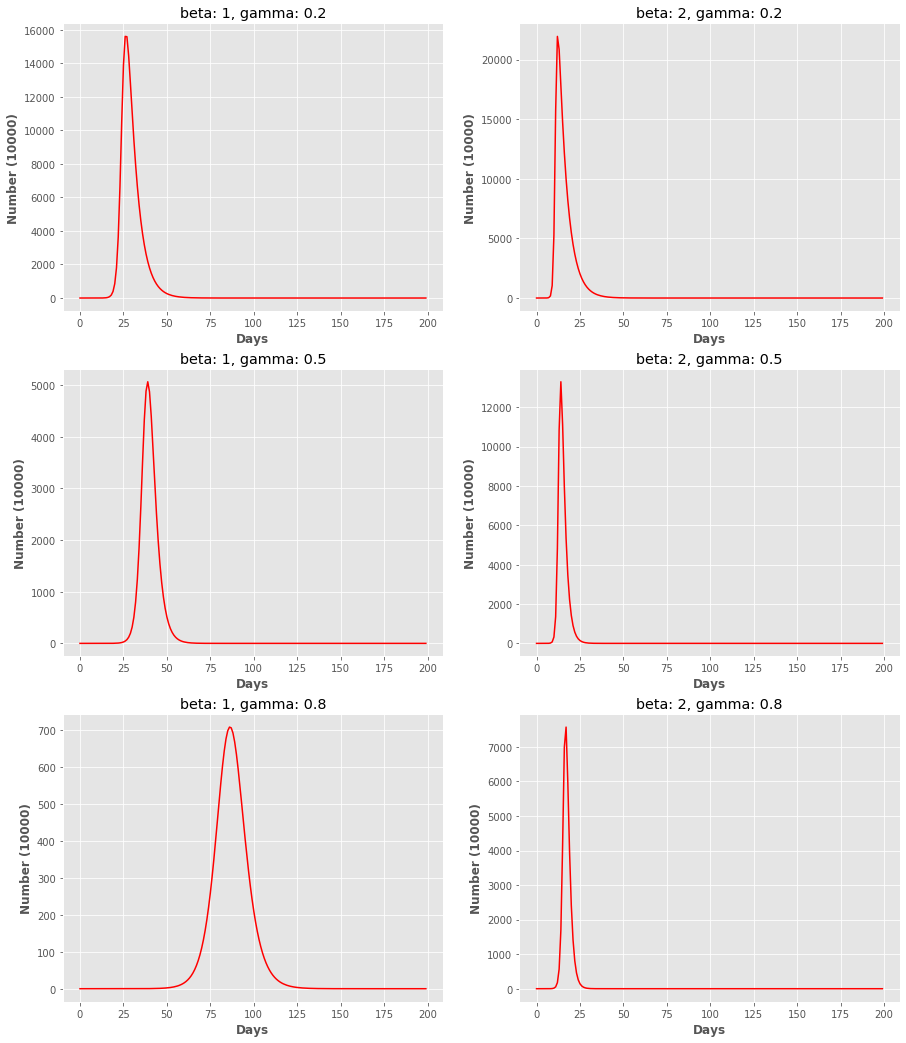

In [6]:
def sirmodel_v2(y, t, N, beta, gamma):
    S,I,R = y
    dsdt = -beta * I * S / N
    didt = beta * I * S / N - gamma * I
    drdt = gamma * I
    return dsdt, didt, drdt
t = np.arange(0,200,1)
betas = [1,2]
gammas = [0.2, 0.5, 0.8]
fig = plt.figure(figsize=(15,18))
i = 1
for gamma in gammas:
    for beta in betas:
        result = odeint(sirmodel_v2, y0, t, args=(N, beta, gamma))
        fig.add_subplot(len(gammas), len(betas), i)
        plt.plot(result[:,1], '-r')
        plt.xlabel("Days",fontweight="bold")
        plt.ylabel("Number (10000)",fontweight="bold")
        title = "beta: " + str(beta) + ", gamma: " + str(gamma)
        plt.title(title)
        i += 1
plt.savefig("figures/sir_sample_inf.jpg", bbox_inches='tight')

# Find the optimal set of parameters

In [7]:
def loss(params, data):
    size = len(data)
    beta, gamma = params
    N = 3.3e4
    def SIR(y, t):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta * I * S / N, beta * I * S / N - gamma * I, gamma * I]
    solution = odeint(SIR, y0, np.arange(0, size, 1))
    return np.sqrt(np.mean((solution[:,1] - data)**2))

bnds = ((0.0001, 1), (0.0001, 1))
optimal = minimize(loss, [0.001, 0.001], args = (data), method='L-BFGS-B', bounds = bnds)
beta_opt = optimal.x[0]
gamma_opt = optimal.x[1]
print("The optimal set of parameters in the range of", bnds, "is beta:", beta_opt, "and gamma: ", gamma_opt)

The optimal set of parameters in the range of ((0.0001, 1), (0.0001, 1)) is beta: 1.0 and gamma:  0.8560326284976323


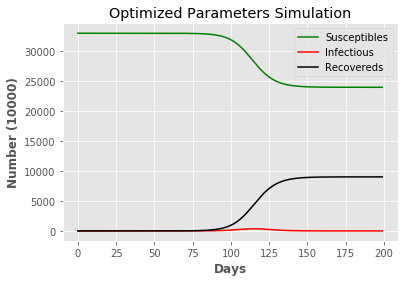

In [8]:
result = odeint(sirmodel_v2, y0, t, args=(N, beta_opt, gamma_opt))
plt.plot(result[:,0], '-g', label='Susceptibles')
plt.plot(result[:,1], '-r', label='Infectious')
plt.plot(result[:,2], '-k', label='Recovereds')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Optimized Parameters Simulation")
plt.savefig("figures/sir_opt_all.jpg", bbox_inches='tight')

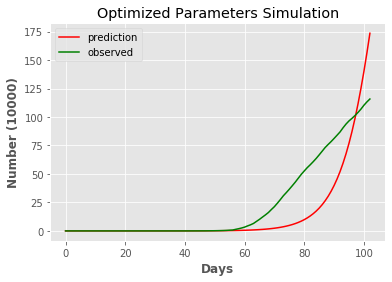

In [9]:
pred_inf = result[:,1][0:103]
plt.plot(pred_inf, '-r', label='prediction')
plt.plot(data, 'g', label = 'observed')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Optimized Parameters Simulation")
plt.savefig("figures/sir_opt_cmp.jpg", bbox_inches='tight')

In [10]:
from sklearn.metrics import r2_score
sir_r2 = r2_score(data, pred_inf)
print("The optimal r2 score for simple SIR model is:", sir_r2)

The optimal r2 score for simple SIR model is: 0.6603792802263296


In [ ]:
plt.plot(result[:,1], '-r', label='Infectious')
plt.xlabel("Days",fontweight="bold")
plt.ylabel("Number (10000)",fontweight="bold")
plt.legend()
plt.title("Optimized Parameters Simulation")
plt.savefig("figures/sir_opt_inf.jpg", bbox_inches='tight')